## Course Project: Text Classification with Rakuten France Product Data

The project focuses on the topic of large-scale product type code text classification where the goal is to predict each product’s type code as defined in the catalog of Rakuten France. This project is derived from a data challenge proposed by Rakuten Institute of Technology, Paris. Details of the data challenge is [available in this link](https://challengedata.ens.fr/challenges/35).

The above data challenge focuses on multimodal product type code classification using text and image data. **For this project we will work with only text part of the data.**

Please read carefully the description of the challenge provided in the above link. **You can disregard any information related to the image part of the data.**

### To obtain the data
You have to register yourself [in this link](https://challengedata.ens.fr/challenges/35) to get access to the data.

For this project you will only need the text data. Download the training files `x_train` and `y_train`, containing the item texts, and the corresponding product type code labels.

### Pandas for handling the data
The files you obtained are in CSV format. We strongly suggest to use Python Pandas package to load and visualize the data. [Here is a basic tutorial](https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/) on how to handle data in CSV file using Pandas.

If you open the `x_train` dataset using Pandas, you will find that it contains following columns:
1. an integer ID for the product
2. **designation** - The product title
3. description
4. productid
5. imageid

For this project we will only need the integer ID and the designation. You can [`drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) the other columns.

The training output file `y_train.csv` contains the **prdtypecode**, the target/output variable for the classification task, for each integer id in the training input file `X_train.csv`.

### Task for the break
1. Register yourself and download the training and test for text data. You do not need the `supplementary files` for this project.
2. Load the data using pandas and disregard unnecessary columns as mentioned above.
3. On the **designation** column, apply the preprocessing techniques.

### Task for the end of the course
After this preprocessing step, you have now access to a TF-IDF matrix that constitute our data set for the final evaluation project. The project guidelines are:
1. Apply all approaches taught in the course and practiced in lab sessions (Decision Trees, Bagging, Random forests, Boosting, Gradient Boosted Trees, AdaBoost, etc.) on this data set. The goal is to predict the target variable (prdtypecode).
2. Compare performances of all these models in terms of the weighted-f1 scores you can output. 
3. Conclude about the most appropriate approach on this data set for the predictive task. 
4. Write a report in .tex format that adress all these guidelines with a maximal page number of 5 (including figures, tables and references). We will take into account the quality of writing and presentation of the report.

In [1]:
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 13.1MB 1.7MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.1.0-cp36-none-any.whl size=13156209 sha256=018c97bd35bcafaf4204d12b5729d51947d16ee75da7fdf3f6f8b4415362329d
  Stored in directory: /tmp/pip-ephem-wheel-cache-v91p8919/wheels/ab/82/2a/61dd0ff02e22f10eef65a5aa35453a0eb745c84b4c874b612f
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [0]:
import numpy as np
import pandas as pd
import spacy
import fr_core_news_sm

# Load spaCy for french
spacy_nlp = fr_core_news_sm.load()

In [3]:
# linking Google-Drive to save plots
from google.colab import drive
drive = drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# create a directory for saving the models and the training progress
save_folder = '/content/drive/My Drive/MScDSBA/Data_Science/Ensemble_Learning/'

In [0]:
# download data
X_train = pd.read_csv(save_folder + 'data/X_train.csv')
Y_train = pd.read_csv(save_folder + 'data/Y_train.csv')
X_test = pd.read_csv(save_folder + 'data/X_test.csv')

In [0]:
# X_train.head()
# Y_train.head()
# X_test.head()

## Pre-processing

1. We only keep the designation and id. 
2. We normalize the accents, put the text in lower-case, remove the punctuation, tokenise the extracts

In [0]:
# designation and ids
def cleaning(X_train): 
    X_train = X_train.drop(['description', 'productid','imageid'], axis=1)
    X_train.columns = ['integer_id', 'designation']
    return X_train

In [0]:
def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('â', 'a')

    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')

    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')
    
    return string

In [0]:
def raw_to_tokens(raw_string, spacy_nlp):
    # Write code for lower-casing
    string = raw_string.lower()
    
    # Write code to normalize the accents
    string = normalize_accent(string)
        
    # Write code to tokenize
    spacy_tokens = spacy_nlp(string)
        
    # Write code to remove punctuation tokens and create string tokens
    string_tokens = [token.orth_ for token in spacy_tokens if not token.is_punct if not token.is_stop]
    
    # Write code to join the tokens back into a single string
    clean_string = " ".join(string_tokens)
    
    return clean_string

### Apply pre-processing functions

N.B.: Section takes about ~20 min to run, skip-it if you have the pre-processed data folders. 

In [0]:
# X_train - step takes roughly ~15:30 min > Uncomment below to run text procesing
X_train = cleaning(X_train)
X_train['designation_cleaned'] = X_train['designation'].progress_apply(lambda x: raw_to_tokens(x, spacy_nlp))

In [0]:
# X_test - step takes roughly ~2:20 min > Uncomment below to run text procesing
X_test = cleaning(X_test)
X_test['designation_cleaned'] = X_test['designation'].progress_apply(lambda x: raw_to_tokens(x, spacy_nlp))

In [0]:
# save folders to avoid re-processing everytime
X_train.to_csv(r(save_folder + 'data/X_train_cleaned.csv'), index = False, header=True)
X_test.to_csv(r(save_folder + 'data/X_test_cleaned.csv'), index = False, header=True)

## TF-IDF matrix

Construct the TF-IDF matrix from the pre-processed data. 

In [0]:
X_train = pd.read_csv(save_folder + 'data/X_train_cleaned.csv')
X_test = pd.read_csv(save_folder + 'data/X_test_cleaned.csv')

In [0]:
# create a list from the processed cells
doc_clean_train =  X_train['designation_cleaned'].astype('U').tolist()
doc_clean_test = X_test['designation_cleaned'].astype('U').tolist()
doc_clean = doc_clean_train + doc_clean_test

In [17]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# convert raw documents into TF-IDF matrix.
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(doc_clean)

print("Shape of the TF-IDF Matrix:")
print(X_tfidf.shape)

Shape of the TF-IDF Matrix:
(98728, 86833)


### PCA of the TFIDF matrix 
We apply a PCA on the TF-IDF matrix to reduce the dimension. Given the matrix is very sparse, this improves the speed of the algorithms. We opt for **XY** principal components corresponding to 85% variance explained. Since the matrix is very sparse, Sparse PCA model is used. 

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html

**Conclusion:** This model is not functional as it requires a lot of memory to store the dense array of size (98728, 86833). 

In [0]:
from sklearn.decomposition import SparsePCA

transformer = SparsePCA(n_components=5, random_state=0)
transformer.fit(X_tfidf.toarray())

X_transformed = transformer.transform(X_tfidf)
X_transformed.shape

# most values in the components_ are zero (sparsity)
np.mean(transformer.components_ == 0)

### Truncated SVD
Since PCA cannot be used here, truncated SVD, a method which is used to reduce the dimensions of TF-IDF matrices is applied on our matrix. We opt for **XY** principal components corresponding to 85% variance explained.

In [28]:
from sklearn.decomposition import TruncatedSVD

# number of chosen SVD components is 1000 only, it should be updated
SVD = TruncatedSVD(n_components = 1000, algorithm='arpack', random_state = 42)
X_transformed = SVD.fit_transform(X_tfidf)

print('Explained variance:')
print(SVD.explained_variance_ratio_.sum())
print(X_transformed.shape)

Explained variance:
0.3814342673501049
(98728, 1000)


<Figure size 720x576 with 0 Axes>

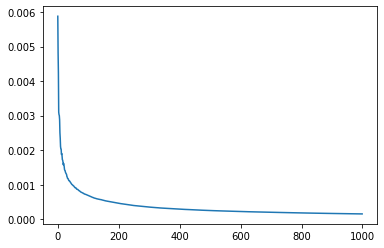

<Figure size 720x576 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
plt.plot(SVD.explained_variance_ratio_)
plt.figure(figsize=(10, 8))
# 1000 : 0.3814 variance explained 

In [0]:
X_transformed = X_tfidf
# print(X_transformed)

### Divide back in train and test

In [51]:
X_train_T = X_transformed[:84916]
X_test_T = X_transformed[84916:]

print(X_train_T.shape) # 84916
print(X_test_T.shape) # 13812

(84916, 86833)
(13812, 86833)


## Apply various models to predict the target variable
1. Decision Trees
2. Bagging
3. Random forests
4. Boosting
5. Gradient Boosted Trees
6. AdaBoost, etc.

### Reduce the dataset to 10% of its initial size for faster training

The selection is done at random i.e. 10% of the training samples are chosen at random within the training set. Assuming the data is uniformly distributed.

In [0]:
# CHOOSE NUMBER OF SAMPLES TESTED
#N = math.ceil(row * 0.1) # 10% of the data
N = 1000

In [128]:
# pick at random 10% of the total samples
import random 
import math 

row, col = X_train_T.shape
rdsample = random.sample(range(1, row), N) 

X_train_sample = X_train_T[rdsample,]
Y_train_sample = Y_train.to_numpy()[rdsample,]
Y_train_sample = pd.DataFrame(Y_train_sample[:,1])

print(X_train_sample.shape)
print(Y_train_sample.shape)

(1000, 86833)
(1000, 2)


### 1. Decision trees

In [158]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

parameters = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
grid_dec_tree = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv = 5, scoring = 'f1_weighted', verbose=1)
result = grid_dec_tree.fit(X_train_sample, Y_train_sample)

# update verbose to 2 for more steps
# add-in progress bar to evaluate time taken / time it will take

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   12.4s finished


In [144]:
# print results from grid search 
result.best_params_
# result.cv_results_

{'criterion': 'gini', 'max_depth': 14}

In [161]:
dec_tree = DecisionTreeClassifier(result.best_params_)
dec_tree = dec_tree.fit(X_train_sample, Y_train_sample)
cross_val_score(dec_tree, X_train_sample, Y_train_sample, cv = 5)

TypeError: ignored

In [163]:
# predict on X_test
Y_test = dec_tree.predict(X_test_T)

AttributeError: ignored

After this preprocessing step, you have now access to a TF-IDF matrix that constitute our data set for the final evaluation project. The project guidelines are:
1. Apply all approaches taught in the course and practiced in lab sessions () on this data set. The goal is to predict the target variable (prdtypecode).
2. Compare performances of all these models in terms of the weighted-f1 scores you can output. 
3. Conclude about the most appropriate approach on this data set for the predictive task. 
4. Write a report in .tex format that adress all these guidelines with a maximal page number of 5 (including figures, tables and references). We will take into account the quality of writing and presentation of the report.